Building ResNet152V2 Model for Image Classification with Small Dataset

Number of classes: 20 (Classes 0-19)
Classes = owl | galaxy | lightning | wine-bottle | t-shirt | waterfall | sword | school-bus | calculator | sheet-music | airplanes | lightbulb | skyscraper | mountain-bike | fireworks | computer-monitor | bear | grand-piano | kangaroo | laptop ]

Dataset Structure
Two folders:
Training: 1554 images
Test: 500 images
Dataset Link

https://github.com/miladfa7/Image-Classification-Transfer-Learning/tree/master/Dataset

In [38]:
!wget https://github.com/miladfa7/Image-Classification-Transfer-Learning/archive/refs/heads/master.zip

--2024-09-19 19:05:31--  https://github.com/miladfa7/Image-Classification-Transfer-Learning/archive/refs/heads/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/miladfa7/Image-Classification-Transfer-Learning/zip/refs/heads/master [following]
--2024-09-19 19:05:31--  https://codeload.github.com/miladfa7/Image-Classification-Transfer-Learning/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.2’

master.zip.2            [          <=>       ]  91.33M  17.8MB/s    in 5.2s    

2024-09-19 19:05:36 (17.5 MB/s) - ‘master.zip.2’ saved [95762116]



In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import zipfile
from google.colab import files
import matplotlib.pyplot as plt

In [40]:
zip_file_path = '/content/master.zip'
extract_dir = '/content/Image-Classification-Transfer-Learning-master'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [41]:
dataset_dir = os.path.join(extract_dir, 'Image-Classification-Transfer-Learning-master', 'Dataset')
train_dir = os.path.join(dataset_dir, 'training')
test_dir = os.path.join(dataset_dir, 'test')

In [42]:
# ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1554 images belonging to 20 classes.


In [43]:
# ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith(('.jpg', '.png'))]

In [44]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

In [45]:
test_images = [preprocess_image(path) for path in test_image_paths]
test_images = tf.concat(test_images, axis=0)

In [46]:
!ls /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/training/

airplanes   computer-monitor  grand-piano  lightbulb	  owl	       skyscraper  waterfall
bear	    fireworks	      kangaroo	   lightning	  school-bus   sword	   wine-bottle
calculator  galaxy	      laptop	   mountain-bike  sheet-music  t-shirt


In [47]:
!ls /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test

IMG_0.jpg     IMG_1264.jpg  IMG_1532.jpg  IMG_1836.jpg	IMG_237.jpg  IMG_513.jpg  IMG_744.jpg
IMG_1001.jpg  IMG_1268.jpg  IMG_1536.jpg  IMG_1837.jpg	IMG_240.jpg  IMG_515.jpg  IMG_74.jpg
IMG_1007.jpg  IMG_1270.jpg  IMG_1538.jpg  IMG_183.jpg	IMG_245.jpg  IMG_517.jpg  IMG_752.jpg
IMG_1011.jpg  IMG_1276.jpg  IMG_153.jpg   IMG_1842.jpg	IMG_249.jpg  IMG_51.jpg   IMG_755.jpg
IMG_1023.jpg  IMG_1280.jpg  IMG_1541.jpg  IMG_1849.jpg	IMG_24.jpg   IMG_524.jpg  IMG_756.jpg
IMG_1031.jpg  IMG_1283.jpg  IMG_1543.jpg  IMG_1851.jpg	IMG_251.jpg  IMG_535.jpg  IMG_764.jpg
IMG_1035.jpg  IMG_1285.jpg  IMG_1544.jpg  IMG_1852.jpg	IMG_252.jpg  IMG_539.jpg  IMG_775.jpg
IMG_1037.jpg  IMG_1289.jpg  IMG_1546.jpg  IMG_1854.jpg	IMG_261.jpg  IMG_53.jpg   IMG_785.jpg
IMG_1042.jpg  IMG_1298.jpg  IMG_1550.jpg  IMG_1858.jpg	IMG_262.jpg  IMG_542.jpg  IMG_789.jpg
IMG_1046.jpg  IMG_129.jpg   IMG_1551.jpg  IMG_1865.jpg	IMG_263.jpg  IMG_543.jpg  IMG_791.jpg
IMG_104.jpg   IMG_1306.jpg  IMG_1552.jpg  IMG_1871.jpg	IMG_264.jpg  IMG_

In [48]:
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Unfreeze the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a dense layer with 1024 units
predictions = Dense(20, activation='softmax')(x)  # Add a final layer for 20 classes

model = Model(inputs=base_model.input, outputs=predictions)

In [49]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 60,450,324 (230.60 MB)

 Trainable params: 58,513,172 (223.21 MB)

 Non-trainable params: 1,937,152 (7.39 MB)

In [51]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=train_generator  # Use a portion of training data as validation data
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.5533 - loss: 1.7788 - val_accuracy: 0.9492 - val_loss: 0.2177
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9394 - loss: 0.2094 - val_accuracy: 0.9640 - val_loss: 0.1335
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9445 - loss: 0.1762 - val_accuracy: 0.9730 - val_loss: 0.1014
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9601 - loss: 0.1392 - val_accuracy: 0.9762 - val_loss: 0.0780
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9684 - loss: 0.1138 - val_accuracy: 0.9704 - val_loss: 0.1123
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9704 - loss: 0.1251 - val_accuracy: 0.9775 - val_loss: 0.0769
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9813 - loss: 0.0749 - val_accuracy: 0.9846 - val_loss: 0.0624
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9748 - loss: 0.0888 - val_accuracy: 0.9891 - val_loss: 0.0455
Ep

In [52]:
# Evaluate the model on training data (as test data isn't labeled)
loss, accuracy = model.evaluate(train_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 482ms/step - accuracy: 0.9958 - loss: 0.0244
Test Loss: 0.027866775169968605
Test Accuracy: 0.9942085146903992


In [53]:
# Predict on test images
predictions = model.predict(test_images)

16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 727ms/step


In [54]:
# Decode predictions
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [class_labels[i] for i in predicted_classes]

In [55]:
# Print predictions
for image_path, label in zip(test_image_paths, predicted_labels):
    print(f"Image: {image_path}, Predicted label: {label}")

Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_845.jpg, Predicted label: wine-bottle
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1406.jpg, Predicted label: wine-bottle
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_121.jpg, Predicted label: wine-bottle
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_880.jpg, Predicted label: wine-bottle
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1706.jpg, Predicted label: t-shirt
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1228.jpg, Predicted label: wine-bottle
Image: /content/Image-C

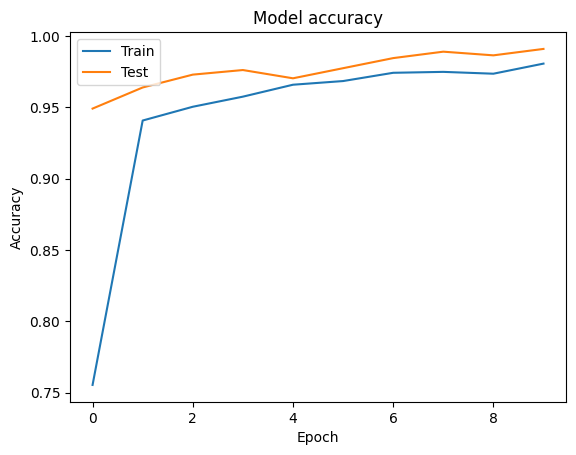

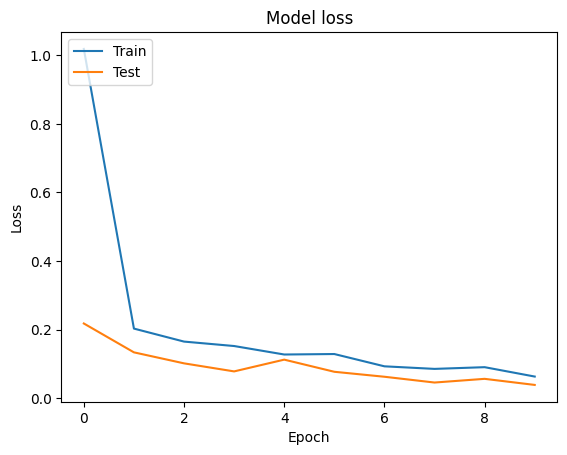

In [56]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [57]:
model.save('my_model.keras')

In [90]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
import numpy as np

In [91]:
model = tf.keras.models.load_model('my_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
The predicted label for the image is: bear


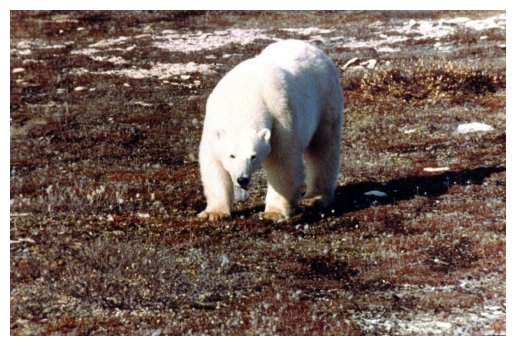

In [92]:
image_path = '/content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1001.jpg'
predicted_label = predict_class_with_label(image_path, model, train_generator.class_indices)
print(f"The predicted label for the image is: {predicted_label}")
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The predicted label for the image is: computer-monitor


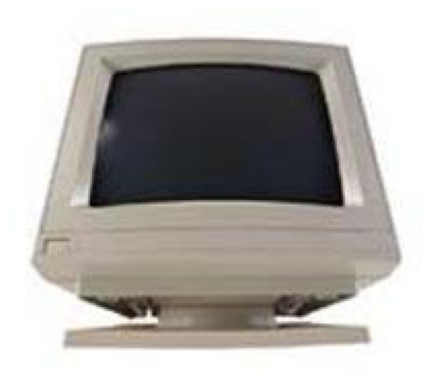

In [94]:
image_path = '/content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1011.jpg'
predicted_label = predict_class_with_label(image_path, model, train_generator.class_indices)
print(f"The predicted label for the image is: {predicted_label}")
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
The predicted label for the image is: owl


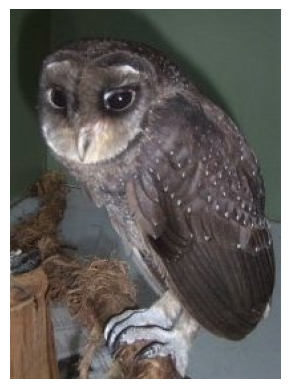

In [95]:
image_path = '/content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1050.jpg'
predicted_label = predict_class_with_label(image_path, model, train_generator.class_indices)
print(f"The predicted label for the image is: {predicted_label}")
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
The predicted label for the image is: mountain-bike


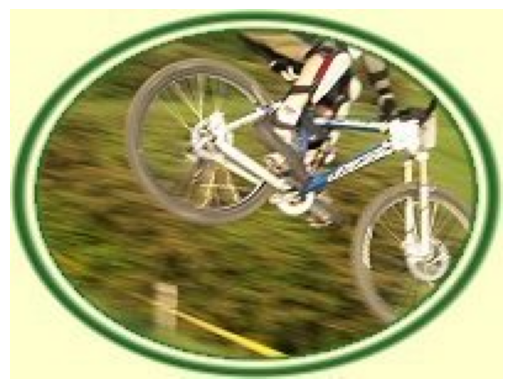

In [96]:
image_path = '/content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1101.jpg'
predicted_label = predict_class_with_label(image_path, model, train_generator.class_indices)
print(f"The predicted label for the image is: {predicted_label}")
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()